# Quickstart

In [79]:
from optiwindnet.api import WindFarmNetwork

In [ ]:
# Display figures as SVG in Jupyter notebooks
%config InlineBackend.figure_formats = ['svg']

In [80]:
import numpy as np
# all coordinates are sequences of (x, y) pairs
# if input coordinates are in arrays X and Y, use `np.hstack((X, Y))`
borderC = np.array( # coordinate sequence defines the polygon, last-first segment implicit
    [[1951, 200], [1951, 1383], [386, 1383], [650, 708], [624, 678],
     [4, 1036], [4, 3], [1152, 3], [917, 819], [957, 854]],
    dtype=float)
obstaclesC = [
    # first obstacle
    np.array([[1540, 920], [1600, 940], [1600, 1150], [1400, 1200]]),
    # [second obstacle] ...
]
substationsC = np.array([[696, 1063],], dtype=float)
turbinesC = np.array(
    [[1940, 279], [1920, 703], [1475, 696], [1839, 1250],
     [1277, 1296], [442, 1359], [737, 435], [1060, 26],
     [522, 176], [87, 35], [184, 417], [71, 878]],
    dtype=float
)

cables = [(3, 206), (5, 287), (7, 406)]

In [81]:
wfn = WindFarmNetwork(turbinesC=turbinesC, substationsC=substationsC, cables=cables, borderC=borderC, obstaclesC=obstaclesC, verbose=True)

<Axes: >

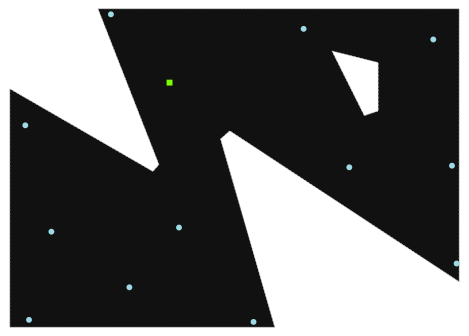

In [82]:
# set Matplotlib option to generate inline SVG
import matplotlib.pyplot as plt
%config InlineBackend.figure_formats = ['svg']
plt.rcParams['svg.fonttype'] = 'none'

# plot location
wfn.plot_location()

## Quickest (sub-second)

The defaul router is Heuristic Esau_Williams.

In [83]:
res_default = wfn.optimize()
# Running optimize without specifying router is equivalent to:
# from optiwindnet.api import Heuristic
# router = Heuristic(solver='Esau_Williams')
# res_Heuristic = wfn.optimize(router=router)

The final solution can be visualized using wfn.plot()

<Axes: >

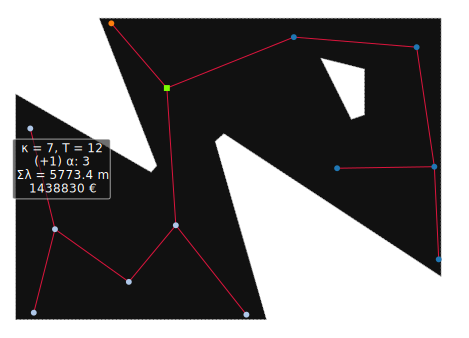

In [84]:
wfn.plot()

## Quick (radial only, a second or two)

In [85]:
from optiwindnet.api import MetaHeuristic

In [86]:
router2 = MetaHeuristic(solver='HGS', time_limit=1)

In [87]:
res_HGS = wfn.optimize(router=router2)

<Axes: >

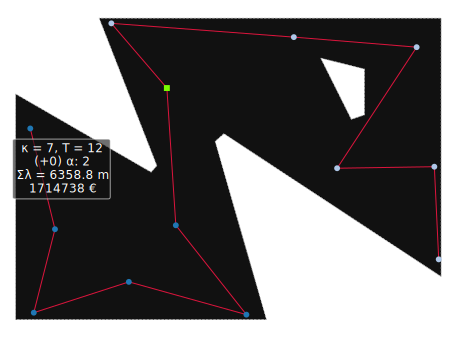

In [88]:
wfn.plot()

This is the optimum RADIAL layout. HGS does not consider branching.

## With quality assurance (a few minutes)

In [89]:
from optiwindnet.api import MILP

In [90]:
solver_options=dict(
        max_time_in_seconds = 300,
        relative_gap_limit = 0.005,
        num_workers = 8,
    )

model_options = {"gateXing_constraint": False,
                 "branching": True,
                 "gates_limit": False}

router_MILP = MILP(solver='ortools', solver_options=solver_options, model_options=model_options, verbose=True)

res_MILP = wfn.optimize(router=router_MILP)

S is not None and the model is warmed up with the available S.

Starting CP-SAT solver v9.12.4544
Parameters: max_time_in_seconds: 300 log_search_progress: true relative_gap_limit: 0.005 num_workers: 8

Initial optimization model '': (model_fingerprint: 0xf7615695f7e40a94)
#Variables: 160 (#bools: 80 in floating point objective)
  - 80 Booleans in [0,1]
  - 68 in [0,6]
  - 12 in [0,7]
#kAtMostOne: 47 (#literals: 122)
#kLinear1: 160 (#enforced: 160)
#kLinearN: 39 (#terms: 400)

Starting presolve at 0.00s
The solution hint is complete and is feasible.
[Scaling] Floating point objective has 80 terms with magnitude in [336.61, 1997.76] average = 871.389
[Scaling] Objective coefficient relative error: 8.90318e-09
[Scaling] Objective worst-case absolute error: 8.03097e-05
[Scaling] Objective scaling factor: 131072
  4.68e-04s  0.00e+00d  [DetectDominanceRelations] 
  1.53e-03s  0.00e+00d  [operations_research::sat::CpModelPresolver::PresolveToFixPoint] #num_loops=2 #num_dual_strengthening=1 

<Axes: >

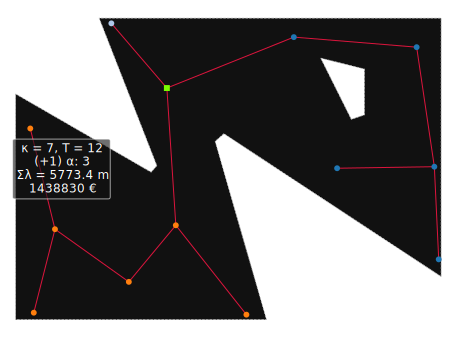

In [91]:
wfn.plot()